In [27]:
import numpy as np
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

%matplotlib inline
import matplotlib.pyplot as plt

# 1. Human capital accumulation (See problem set 7)

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & w h_2 l_2 \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_1 &=& w h_1 l_1 \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [87]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [88]:
h_vec = np.linspace(0.1,1.5,100) 

**Define initial functions**

In [89]:
# define utility of consumtion
def utility(c, rho):
    return c**(1-rho)/(1-rho)

# define disutility from working 
def disutility(gamma, l):
    return gamma*l

# define period 2
def v2(c2, rho, gamma, l2):
    return utility(c2,rho) - disutility(gamma, l2)

# define human capital in period 1
def v1(c1, h1, rho, gamma, beta, Delta, v2_interp, l1):
    
    # case 1: v2 if low h2
    h2_low = h1 + l1
    v2_low = v2_interp([h2_low])[0]
    
    # case 2: v2 if high h2
    h2_high = h1 + l1 + Delta
    v2_high = v2_interp([h2_high])[0]
    
    # expected value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    #return result
    return utility(c1,rho) - disutility(gamma, l1) + beta*v2


**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

In [90]:
# Define the functions to solve the model in period two

def get_solution_period_two(rho, gamma, Delta, l2 = 1):
    
    # first we define the grids'
    h2_vec = np.linspace(0.1,1.5,100)
    v2_vec = np.empty(100) # this is just empty for now 
    c2_vec = np.empty(100) # this is just empty for now 
   
    
    #next, we solve the model for each h2 value in the grid above
    for i, h2 in enumerate(h2_vec):
        
        # The objective to solve
        objective = lambda c2: -v2(c2, rho, gamma, l2)
        
        # define an initial value to optimize
        x0 = h2/2
        
        #Optimize (by minimizing) and store the result
        result = optimize.minimize_scalar(objective, x0, method='bounded',bounds=[0.1, h2]) #Here the bounds are the min in h_vec linspace
        
        #Save the results
        v2_vec[i] = -result.fun
        c2_vec[i] = result.x
        
    return h2_vec,v2_vec,c2_vec

In [91]:
# Solving the model 

h2_vec,v2_vec,c2_vec = get_solution_period_two(rho, gamma, Delta, l2 = 1)
       
# Construct interpolator
v2_interp = interpolate.RegularGridInterpolator((h2_vec,), v2_vec,
                                                bounds_error=False,fill_value=None)


Text(0, 0.5, '$c_2$')

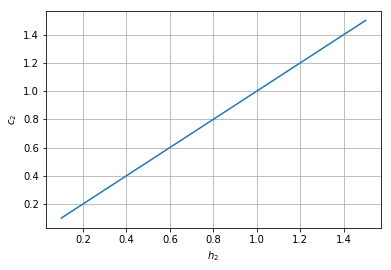

In [92]:
# plot result 

# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(h2_vec,c2_vec)
ax.grid()
ax.set_xlabel('$h_2$')
ax.set_ylabel('$c_2$')
#ax.set_title('consumption function in period 1')
#ax.set_xlim([0,4])
#ax.set_ylim([0,2.5]);

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 

In [93]:
# Define the functions to solve the model

def get_solution_period_one(rho, gamma, Delta, v1, v2_interp, l1):
    
    # first we define the grids'
    h1_vec = np.linspace(0.1,1.5,100)
    v1_vec = np.empty(100) # this is just empty for now 
    c1_vec = np.empty(100) # this is just empty for now 
   
    
    #next, we solve the model for each h2 value in the grid above
    for i, h1 in enumerate(h1_vec):
        
        # The objective to solve
        objective = lambda c1: -v1(c1, h1, rho, gamma, beta, Delta, v2_interp, l1)
        
        # define an initial value to optimize
        x0 = h1/2
        
        #Optimize (by minimizing) and store the result
        result = optimize.minimize_scalar(objective, x0, method='bounded',bounds=[0.1, h1]) #Here the bounds are the min in h_vec linspace
        
        #Save the results
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x
        
    return h1_vec,v1_vec,c1_vec

In [94]:
# solve period one 

h1_vec,v1_vec,c1_vec = get_solution_period_one(rho, gamma, Delta, v1, v2_interp, l1 = 0)

Text(0, 0.5, '$c_1$')

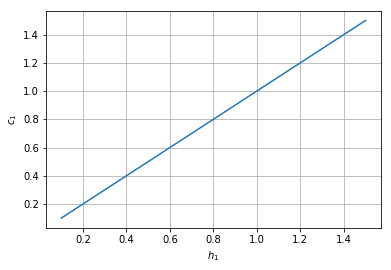

In [95]:
# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(h1_vec,c1_vec)
ax.grid()
ax.set_xlabel('$h_1$')
ax.set_ylabel('$c_1$')
#ax.set_title('consumption function in period 1')
#ax.set_xlim([0,4])
#ax.set_ylim([0,2.5]);

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

Ansver: The worker will only work if she gets utility from working and not disutility from working. She will only work if gamma < 0.

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [4]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.


**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [5]:
par['delta'] = 0.80
par['omega'] = 0.15

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [6]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

# 3. Exchange economy (Problem set 2)

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [271]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1:** Plot the histograms of the budget shares for each good across agents.

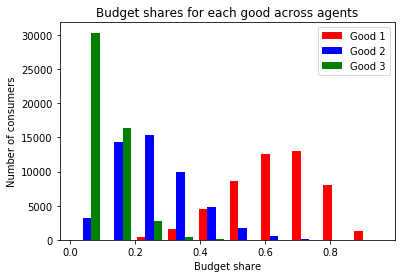

In [272]:
# Histogram of the budget shares for each of the three goods
colors = ['red', 'blue', 'green'] # define colors
plt.hist(betas, bins = 10, color=colors, label=['Good 1', 'Good 2', 'Good 3']) #create histogram from array of betas
plt.title('Budget shares for each good across agents') # title
plt.xlabel('Budget share') #xlabel
plt.ylabel('Number of consumers') #ylabel
plt.legend() # add legend

We see that good number one has the highest budget shares, which indicates that this is the most valuable good. <br>
Further good three has the lowest budget shares.


Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

**Question 2:** Plot the excess demand functions.

In [273]:
# Save the values of beta1, beta2, beta3 across agents respectively
betas_good_one = [x[0] for x in betas]
betas_good_two = [x[1] for x in betas]
betas_good_three = [x[2] for x in betas]

In [274]:
#Define demand function for each good

def demand_func(betas,p1,p2,p3,e1,e2,e3, good):
    if good == 1:
        betas_good_one = [x[0] for x in betas]
        I = p1*e1+p2*e2+p3*e3
        return betas_good_one*I/p1
    if good == 2:
        betas_good_two = [x[1] for x in betas]
        I = p1*e1+p2*e2+p3*e3
        return betas_good_two*I/p2

    if good == 3:
        betas_good_three = [x[2] for x in betas]
        I = p1*e1+p2*e2+p3*e3
        return betas_good_three*I/p3

In [275]:
# Define excess demand function for each good 
def excess_demand_func(alphas,p1,p2, p3,e1,e2, e3, good):
    
    # a. demand
    demand = np.sum(demand_func(betas,p1,p2,p3,e1,e2,e3, good))
    
    # b. supply (depend on the good)
    if good == 1:
        supply = np.sum(e1)
    if good == 2:
        supply = np.sum(e2)
    if good == 3:
        supply = np.sum(e3) 
    
    # c. excess demand
    excess_demand = demand-supply
    
    return excess_demand

In [276]:
# plot the excess demand function 

# create x values
prices_good_one = prices_good_two = prices_good_three = np.linspace(0,2,18)

# create inital values and empty lists
excess_demand_good_one = []
excess_demand_good_two = [] 
excess_demand_good_three = [] 
p1 = 1
p2 = 1
p3 = 1

# Obtain the excess demand for each good
for num in prices_good_one:
    excess_demand_good_one.append(excess_demand_func(alphas,num,p2,p3,e1,e2,e3, good = 1))
    
for num in prices_good_two:
    excess_demand_good_two.append(excess_demand_func(alphas,p1, num,p3,e1,e2,e3, good = 2))
    
for num in prices_good_three:
    excess_demand_good_three.append(excess_demand_func(alphas,p1,p2,num,e1,e2,e3, good = 3))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


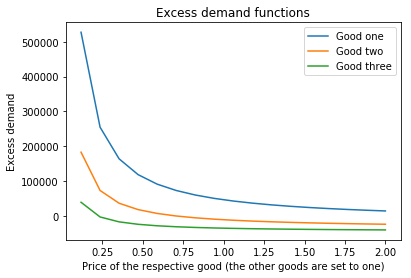

In [277]:
# plot the result

plt.plot(prices_good_one, excess_demand_good_one, label = 'Good one')
plt.plot(prices_good_one, excess_demand_good_two, label = 'Good two')
plt.plot(prices_good_one, excess_demand_good_three, label = 'Good three')
plt.legend() # set legend
plt.title('Excess demand functions') # title
plt.xlabel('Price of the respective good (the other goods are set to one)') #xlabel
plt.ylabel('Excess demand') #ylabel
plt.show()

**Quesiton 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

In [278]:
def find_equilibrium(betas,p1,p2, p3,e1,e2, e3,kappa=0.5,eps=1e-8,maxiter=700):
    
    t = 0
    while True:

        # a. step 1: excess demand
        Z1 = excess_demand_good_1_func(betas,p1,p2,p3,e1,e2,e3)
        Z2 = excess_demand_good_2_func(betas,p1,p2,p3,e1,e2,e3)
        
        # b: step 2: stop?
        if  (np.abs(Z1) < eps and np.abs(Z2) < eps) or t >= maxiter:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excess demand -> {Z1:14.8f}')
            print(f'{t:3d}: p2 = {p2:12.8f} -> excess demand -> {Z1:14.8f}')
            break    
    
        # c. step 3: update p1
        p1 = p1 + kappa*Z1/betas.size
        p2 = p2 + kappa*Z2/betas.size
            
        # d. step 4: return 
        if t < 5 or t%25 == 0:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excess demand -> {Z1:14.8f}')
            print(f'{t:3d}: p2 = {p2:12.8f} -> excess demand -> {Z2:14.8f}')
        elif t == 5:
            print('   ...')
            
        t += 1    

    return p1, p2

In [279]:
# Set initial values
p1 = 1.4
p2 = 1
p3 = 1
kappa = 0.5
eps = 1e-8
p1,p2 = find_equilibrium(betas,p1,p2, p3,e1,e2, e3,kappa=kappa,eps=eps)

  0: p1 =   1.37973738 -> excess demand -> -6078.78547887
  0: p2 =   0.97973738 -> excess demand -> -6078.78547887
  1: p1 =   1.36072543 -> excess demand -> -5703.58688816
  1: p2 =   0.96072543 -> excess demand -> -5703.58688816
  2: p1 =   1.34293491 -> excess demand -> -5337.15508587
  2: p2 =   0.94293491 -> excess demand -> -5337.15508587
  3: p1 =   1.32633197 -> excess demand -> -4980.88210779
  3: p2 =   0.92633197 -> excess demand -> -4980.88210779
  4: p1 =   1.31087848 -> excess demand -> -4636.04661785
  4: p2 =   0.91087848 -> excess demand -> -4636.04661785
   ...
 25: p1 =   1.16728913 -> excess demand ->  -642.43316291
 25: p2 =   0.76728913 -> excess demand ->  -642.43316291
 50: p1 =   1.15010462 -> excess demand ->   -39.17243132
 50: p2 =   0.75010462 -> excess demand ->   -39.17243132
 75: p1 =   1.14908447 -> excess demand ->    -2.27040386
 75: p2 =   0.74908447 -> excess demand ->    -2.27040386
100: p1 =   1.14902544 -> excess demand ->    -0.13119037
100: p2

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

In [280]:
# Define utility function

def utility(p1,p2,p3, e1,e2, e3 ,betas, gamma):
    
    # retrive the demands for each good
    x1 = demand_good_1_func(betas,p1,p2,p3,e1,e2,e3)
    x2 = demand_good_2_func(betas,p1,p2,p3,e1,e2,e3)
    x3 = demand_good_3_func(betas,p1,p2,p3,e1,e2,e3)
    
    # save the beta values
    betas_good_one = np.array([x[0] for x in betas])
    betas_good_two = np.array([x[1] for x in betas])
    betas_good_three = np.array([x[2] for x in betas])
    
    # return the utility for each consumer
    return ((x1**betas_good_one)*(x2**betas_good_two)*(x3**betas_good_three))**gamma
    

In [281]:
# Set values. Here p1 and p2 is equal to the optimal value from question 3.
# p3 is set to one

p1 = 1.14686375
p2 = 0.74686375
p3 = 1

In [282]:
utility_result = utility(p1,p2,p3, e1,e2, e3,betas, gamma)

Text(0, 0.5, 'Number of consumers')

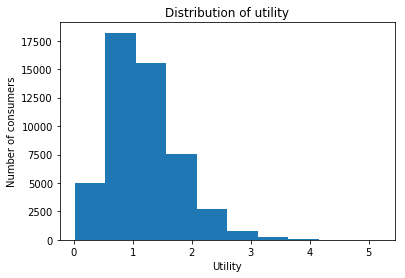

In [283]:
# plot the results
plt.hist(utility_result, bins = 10) # Set the number of bins to 10
plt.title('Distribution of utility') # title
plt.xlabel('Utility') #xlabel
plt.ylabel('Number of consumers') #ylabel

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?

In [284]:
# set endowment for each good to one
e1 = e2 = e3 = np.full((50000), 1)

In [285]:
# Set values. Here p1 and p2 is equal to the optimal value from question 3.
# p3 is set to one

p1 = 1.14686375
p2 = 0.74686375
p3 = 1

In [313]:
utility_result_new = utility(p1,p2,p3, e1,e2, e3,betas, gamma)
utility_result_new_gamma_high = utility(p1,p2,p3, e1,e2, e3,betas, gamma = 2)

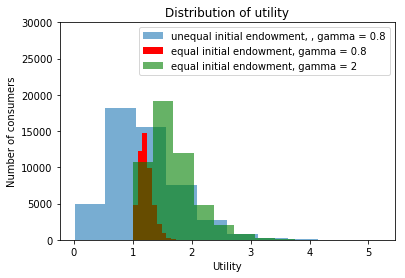

In [316]:
# plot the results
plt.hist(utility_result, bins = 10, alpha = 0.6, label = 'unequal initial endowment, , gamma = 0.8') # Set the number of bins to 10
plt.hist(utility_result_new, bins = 10, alpha = 1, color = 'red', label = 'equal initial endowment, gamma = 0.8') # Set the number of bins to 10
plt.hist(utility_result_new_gamma_high, bins = 10, alpha = 0.6, color = 'green', label = 'equal initial endowment, gamma = 2') # Set the number of bins to 10

plt.title('Distribution of utility') # title
plt.xlabel('Utility') #xlabel
plt.ylabel('Number of consumers') #ylabel
plt.ylim([0,30000])
plt.legend() # add legend

Result: 